In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import (
    get_mixture_time,
    get_stationary_distribution,
    simulate_markov_chain
)

In [2]:
time_unit = 'seconds'
queue_size = 2000
consumer_lambda = 1099
producer_lambda = 1100
producer_distribution = stats.poisson(producer_lambda)
consumer_distribution = stats.poisson(consumer_lambda)
# The Skellam distribution is the difference of two independent Poisson
liquid_distribution = stats.skellam(producer_lambda,
                                    consumer_lambda)

[None]

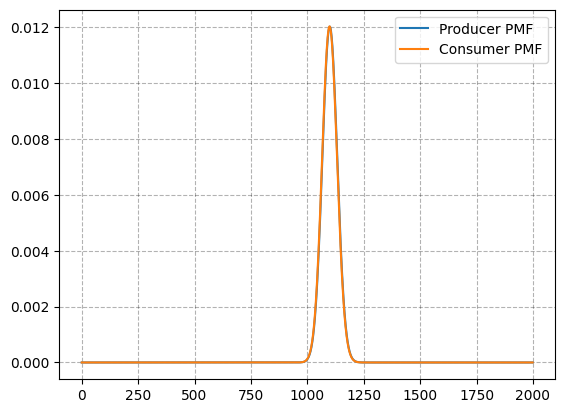

In [3]:
fig, ax = plt.subplots()
x = np.arange(2e3)
producer_pmf = producer_distribution.pmf(x)
consumer_pmf = consumer_distribution.pmf(x)
ax.grid(alpha=.3, color='k', linestyle='--')
ax.plot(x, producer_pmf, label='Producer PMF')
ax.plot(x, consumer_pmf, label='Consumer PMF')
ax.legend()
ax.set(
    yscale='linear'
)

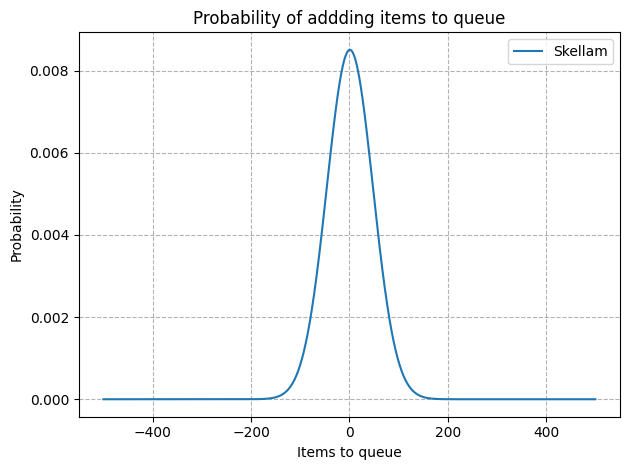

In [4]:
fig, ax = plt.subplots()
x = np.arange(-500, 501)
liquid_pmf = liquid_distribution.pmf(x)
ax.grid(alpha=.3, color='k', linestyle='--')
ax.plot(x, liquid_pmf, label='Skellam')
ax.legend()
ax.set(
    xlabel='Items to queue',
    ylabel='Probability',
    title='Probability of addding items to queue',
)
fig.tight_layout()

In [5]:
mean, var, skew, kurt = stats.skellam.stats(producer_lambda, consumer_lambda, moments='mvsk')
mean, var, skew, kurt

(np.float64(1.0),
 np.float64(2199.0),
 np.float64(9.697552868976043e-06),
 np.float64(0.00045475216007276033))

In [6]:
def get_transition_matrix(
        producer_lambda: float,
        consumer_lambda: float,
        queue_size: int
):
    skellam = stats.skellam(producer_lambda,
                            consumer_lambda)
    P = np.zeros((queue_size + 1, queue_size + 1))
    row_iterator = tqdm(
        range(queue_size + 1),
        desc='Transition Matrix',
        unit='rows filled'
    )
    for i in row_iterator:
        P[i, 0] = skellam.cdf(-i)
        P[i, queue_size] = 1-skellam.cdf(queue_size - i - 1)
        P[i, 1:queue_size] = skellam.pmf(np.arange(1-i, queue_size-i))
    return P


In [7]:
transition_matrix = get_transition_matrix(
    producer_lambda=producer_lambda,
    consumer_lambda=consumer_lambda,
    queue_size=queue_size
)

Transition Matrix: 100%|██████████| 2001/2001 [00:05<00:00, 346.46rows filled/s]


In [8]:
(stationary_distribution,
 residuals,
 _, _) = get_stationary_distribution(
    transition_matrix=transition_matrix
)

/tmp/ipykernel_2858/696355549.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


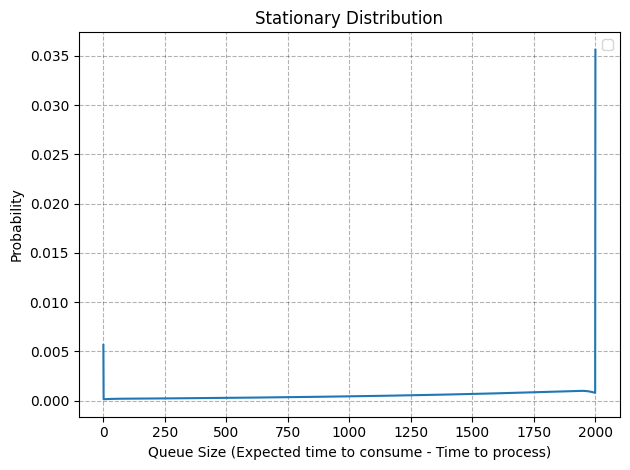

In [9]:
fig, ax = plt.subplots()
x = np.arange(len(stationary_distribution))
ax.grid(alpha=.3, color='k', linestyle='--')
ax.plot(x, stationary_distribution)
ax.legend()
ax.set(
    title='Stationary Distribution',
    xlabel='Queue Size (Expected time to consume - Time to process)',
    ylabel='Probability',
)
fig.tight_layout()

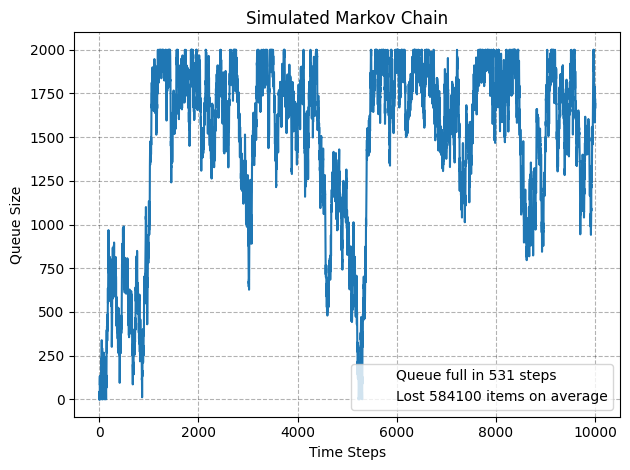

In [13]:
trajectory = simulate_markov_chain(
    transition_matrix=transition_matrix,
    initial_state=0,
    n_steps=10000
)
fig, ax = plt.subplots()
x = np.arange(len(trajectory))
ax.grid(alpha=.3, color='k', linestyle='--')
ax.plot(x, trajectory)
queue_is_full_occurences = np.sum(trajectory == 2000)
ax.plot([], [], ' ', label=f'Queue full in {queue_is_full_occurences} steps')
ax.plot([], [], ' ', label=f'Lost {np.ceil(queue_is_full_occurences*producer_lambda)} items on average')
ax.legend()
ax.set(
    title='Simulated Markov Chain',
    xlabel='Time Steps',
    ylabel='Queue Size',
)
fig.tight_layout()

/tmp/ipykernel_2858/1092026668.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


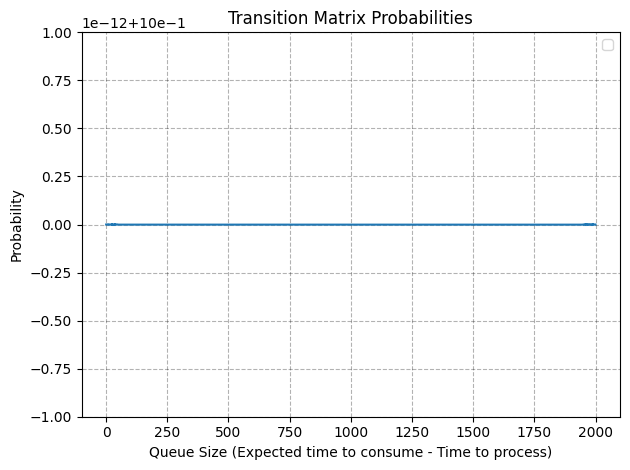

In [11]:
probabilities = transition_matrix.sum(axis=1)
fig, ax = plt.subplots()
x = np.arange(len(probabilities))
ax.grid(alpha=.3, color='k', linestyle='--')
ax.plot(x, probabilities)
ax.legend()
ax.set(
    title='Transition Matrix Probabilities',
    xlabel='Queue Size (Expected time to consume - Time to process)',
    ylabel='Probability',
    ylim=(1-1e-12, 1+1e-12),
)
fig.tight_layout()